In [1]:
import random
import os
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.min_rows', 50)

In [3]:
# Path to data location
DATA_DIR = '../data/price-volume-data-for-all-us-stocks-etfs/Data'

# TODO: Update from Small to Regular (delete Small)
if True:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs')
else:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks_Small')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs_Small')

FILE_SUFFIX = '.us.txt'

In [181]:
def get_tickers(dirname):
    tickers = []
    for file in os.listdir(dirname):
        # This dataset includes empty files which we exclude here.
        if os.stat(os.path.join(dirname, file)).st_size > 0:
            tickers.append(file.replace(FILE_SUFFIX, ''))

    return tickers

def get_etf_tickers():
    return sorted(get_tickers(ETF_DATA_DIR))

def get_stock_tickers():
    return sorted(get_tickers(STOCK_DATA_DIR))

def get_all_tickers():
    return sorted(get_etf_tickers() + get_stock_tickers())

def get_csv_data(ticker, start_date=None, end_date=None):
    ticker = ticker.lower()

    if ticker in get_etf_tickers():
        dirname = ETF_DATA_DIR
    else:
        dirname = STOCK_DATA_DIR

    result = pd.DataFrame()
    csv = pd.read_csv(os.path.join(dirname, ticker + FILE_SUFFIX))
    result = pd.DataFrame({'date': csv['Date'], 'ticker': ticker, 'price': csv['Close'], 'volume': csv['Volume']})
    result['date'] = result['date'].map(lambda t: datetime.strptime(t, '%Y-%m-%d')).to_numpy()

    if start_date is not None:
        result = result[result['date'] >= start_date]
        
    if end_date is not None:
        result = result[result['date'] <= end_date]

    result.index = result.date
    
    # Making sure to only include weekdays
    result['dayofweek'] = pd.DatetimeIndex(result.index).dayofweek
    result = result[(result.dayofweek != 5) & (result.dayofweek != 6)]

    return result

In [182]:
t = get_csv_data('spy', start_date='2016-01-01', end_date='2017-01-01')
t.tail()

,date,ticker,price,volume,dayofweek
date,,,,,
2016-12-23,2016-12-23,spy,222.54,37175258,4
2016-12-27,2016-12-27,spy,223.10,43232763,1
2016-12-28,2016-12-28,spy,221.26,64927525,2
2016-12-29,2016-12-29,spy,221.21,49307251,3
2016-12-30,2016-12-30,spy,220.39,110550190,4


In [6]:
# TODO: 
class EquityData:
    def __init__(self, date_list, price_list):
        self.date = date_list
        self.price = price_list
        self.dates = self.date
        self.prices = self.price

    def __len__(self):
        return len(self.date)
    
    def __getitem__(self, idx):
        return type(self)(self.dates[idx], self.prices[idx])

In [7]:
example_ticker = 'spy'

In [8]:
stocks = {}

In [183]:
from abc import ABC, abstractmethod

class Strategy(ABC):

    def __init__(self):
        self.signals = []

    def buy_signal(self, date):
        self.signals.append([self.ticker, date, 'buy'])
        #print(self.signals[-1])

    def sell_signal(self, date):
        self.signals.append([self.ticker, date, 'sell'])
        #print(self.signals[-1])

    def get_signals(self):
        signals_df = pd.DataFrame(data=self.signals, columns=['ticker', 'date', 'signal'])
        signals_df.index = signals_df.date
        return signals_df
    
    @abstractmethod
    def precalc(self, data):
        pass
    
    @abstractmethod
    def execute(self, data):
        pass

    @abstractmethod
    def plot(self, data):
        pass

In [10]:
class SimpleMovingAvgCrossOverStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()

        self.ticker = ticker
        
        if config:
            self.sma_short = config['sma_short']
            self.sma_long = config['sma_long']
        else:
            self.sma_short = 100
            self.sma_long = 300

        self.invested = False
        
    def precalc(self, data):
        data['sma_short'] = data['price'].rolling(self.sma_short, min_periods=self.sma_short).mean()
        data['sma_long'] = data['price'].rolling(self.sma_long, min_periods=self.sma_long).mean()

    def execute(self, data):
        for _, data in data.iterrows():
            if data['sma_short'] > data['sma_long'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['sma_short'] < data['sma_long'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False
                
    def plot(self, data):
        plt.plot(data.date, data['sma_short'], label='{}-Day Moving Avg'.format(self.sma_short), 
                 color='darkorange', zorder=0)
        plt.plot(data.date, data['sma_long'], label='{}-Day Moving Avg'.format(self.sma_long), 
                 color='brown', zorder=0)

In [11]:
class BuyAndHoldStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker.lower()
        self.invested = False
        
    def precalc(self, data):
        pass

    def execute(self, data):
        for _, data in data.iterrows():
            if not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
    
    def plot(self, data):
        pass

In [28]:
class BandStrategy(Strategy):

    def execute(self, data):
        for _, data in data.iterrows():
            if data['price'] < data['band_low'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['price'] > data['band_high'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False

    
class BollingerBandStrategy(BandStrategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker

        if config:
            self.sma = config['sma']
            self.sd = config['sd']
        else:
            self.sma = 20
            self.sd = 2

        self.invested = False

    def precalc(self, data):
        data['sma'] = data['price'].rolling(self.sma, min_periods=self.sma).mean()
        data['sd'] = data['price'].rolling(self.sma, min_periods=self.sma).std()
        data['band_high'] = data['sma'] + self.sd * data['sd']
        data['band_low'] = data['sma'] - self.sd * data['sd']
        
    def plot(self, data):
        plt.fill_between(data.date, data['band_high'], data['band_low'],
                         label='{}-Day Band'.format(self.sma), color='pink', zorder=-1)
        plt.plot(data.date, data['sma'], label='{}-Day Moving Avg'.format(self.sma), 
                 color='blue', zorder=0)

Bollinger


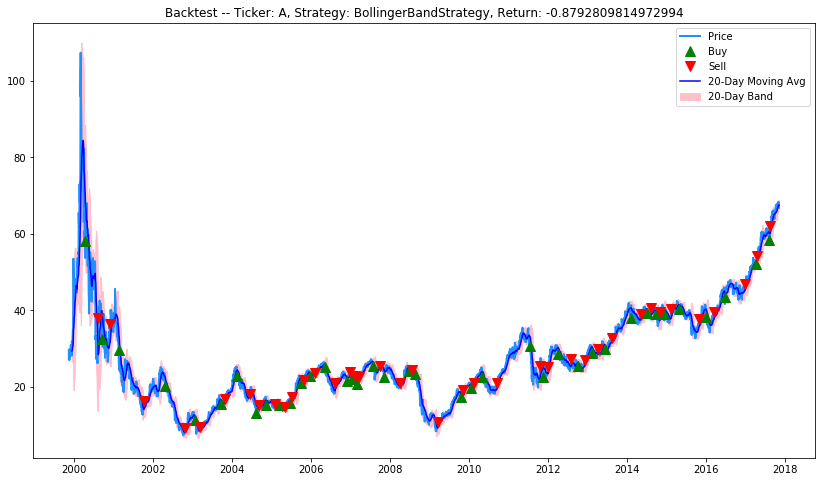

-0.8792809814972994


AttributeError: 'Backtest' object has no attribute 'daily_returns'

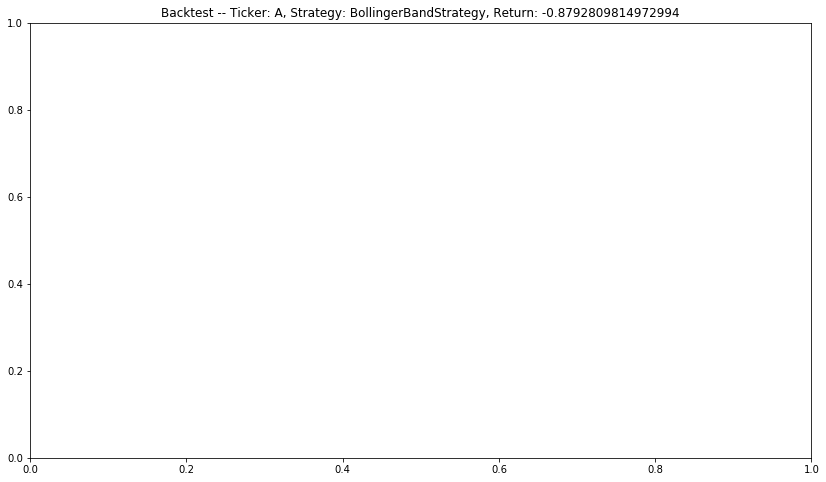

In [748]:
class Backtest():

    def __init__(self, strategy_cls, ticker, config={}, start_date=None, end_date=None):
        self.ticker = ticker.lower()
        self.config = config
        self.start_date = start_date
        self.end_date = end_date
        self.strategy = strategy_cls(ticker, config)
        self.data = None
        self.signals = None
        self.buys = None
        self.sells = None

    def run(self):
        self.data = None
        self.signals = None
        self.buys = None
        self.sells = None

        self.data = get_csv_data(self.ticker, self.start_date, self.end_date)
        self.strategy.precalc(self.data)
        self.strategy.execute(self.data)

        self.signals = self.strategy.get_signals()
        self.buys = self.data.loc[self.signals[self.signals.signal == 'buy'].index]['price']
        self.sells = self.data.loc[self.signals[self.signals.signal == 'sell'].index]['price']

        if len(self.buys) > len(self.sells):
            self.sells = self.sells.append(self.data['price'][[-1]])

        # We need to account for the scenario when we buy on the last day.
        if len(self.buys) > 0:
            if len(self.buys) != len(self.sells) or any(self.buys.index[:-1] >= self.sells.index[:-1]) or (self.buys.index[-1] > self.sells.index[-1]):
                raise Exception('Strategy buys and sells are not consistent.')

        daily = self.calc_daily_returns()
        total = self.calc_total_return()
        sharpe = self.calc_sharpe_ratio()
        cagr = self.calc_cagr()

        stats = {}
        stats['total_return'] = total
        stats['daily_return'] = daily['daily_return']
        stats['cum_return'] = daily['cum_return']
        stats['sharpe'] = daily['sharpe']
        stats['cagr'] = daily['cagr']
        return 

    def calc_total_return(self):
        return np.prod(self.sells.values / self.buys.values) - 1
    
    def calc_daily_returns(self):
        is_buy_list = np.full(len(self.data), False)
        is_buy_list[np.in1d(self.data.index, buys.index)] = True

        is_sell_list = np.full(len(self.data), False)
        is_sell_list[np.in1d(self.data.index, sells.index)] = True

        invested = False
        buy_shares = 0
        cash = 1000
        buy_shares = 0
        prev_total = 0
        total = cash

        ratios = []
        for price, is_buy, is_sell in zip(self.data.price, is_buy_list, is_sell_list):
            #print(price, is_buy, is_sell, buy_shares, cash)

            if is_buy:
                owned = True
                buy_shares = cash / price
                cash = 0
            elif is_sell:
                owned = False
                cash = buy_shares * price
                buy_shares = 0

            total = cash + price * buy_shares

            #print(price, buy_shares, cash, total, prev_total, (total / prev_total) if prev_total != 0 else np.nan)

            if prev_total != 0:
                ratios.append((total / prev_total) - 1)
            else:
                ratios.append(np.nan)

            prev_total = total

        ratios = np.array(ratios)
        rets = (1 + ratios)
        rets[np.isnan(rets)] = 1
        cum_returns = np.cumprod(rets) - 1

        self.daily_returns = pd.DataFrame({'daily_return': ratios, 'cum_return': cum_returns}, index=data.index)
        return returns
    
    def calc_sharpe_ratio(self):
        rets = self.daily_returns
        # TODO: 252
        return np.sqrt(252) * np.mean(rets['daily_return']) / np.std(rets['daily_return'])

    def calc_cagr(self):
        rets = self.daily_returns
        # TODO: 252
        return rets['cum_return'][-1] ** (252 / len(rets))
    
    def plot(self):
        fig = plt.figure(figsize=(14,8))

        plt.title('Backtest -- Ticker: {}, Strategy: {}, Return: {}'.format(
            self.ticker.upper(), type(self.strategy).__name__, float(self.calc_total_return())))

        plt.plot(self.data.date, self.data.price, color='dodgerblue', lw=2., label='Price', zorder=0)

        plt.plot(self.data.loc[backtest.buys.index].index, self.data.price[backtest.buys.index], 
                 '^', markersize=10, color='g', label='Buy')
        plt.plot(self.data.loc[backtest.sells.index].index, self.data.price[backtest.sells.index],
                 'v', markersize=10, color='r', label='Sell')
        
        self.strategy.plot(self.data)

        plt.legend()
        plt.show()

    def plot_returns(self):
        fig = plt.figure(figsize=(14,8))

        plt.title('Backtest -- Ticker: {}, Strategy: {}, Return: {}'.format(
            self.ticker.upper(), type(self.strategy).__name__, float(self.calc_total_return())))

        plt.plot(self.data.date, self.daily_returns['cum_return'], color='dodgerblue', lw=2., label='Price', zorder=0)

        plt.legend()
        plt.show()
        
if True:
    print('Bollinger')
    backtest = Backtest(BollingerBandStrategy, 'a')
    backtest.run()
    backtest.plot()

    
if False:        
    example_ticker = 'SPY'

    print('SMA')
    backtest = Backtest(SimpleMovingAvgCrossOverStrategy, example_ticker)
    backtest.run()
    backtest.plot()

    print('BuyAndHold')
    backtest = Backtest(BuyAndHoldStrategy, example_ticker)
    backtest.run()
    backtest.plot()

    print('Bollinger')
    backtest = Backtest(BollingerBandStrategy, example_ticker, start_date='2016-01-01', end_date='2016-12-31')
    backtest.run()
    backtest.plot()

print(backtest.calc_total_return())
#rets = backtest.calc_daily_returns()
#print(rets.iloc[-1])
#print(backtest.calc_sharpe_ratio())
backtest.plot_returns()

date
1999-11-18    10.0
1999-11-19    20.0
1999-11-22    30.0
1999-11-23    40.0
1999-11-24    50.0
Name: price, dtype: float64

date
1999-11-18    10.0
1999-11-23    40.0
Name: price, dtype: float64
date
1999-11-22    30.0
1999-11-24    50.0
Name: price, dtype: float64


,returns
0,0.00
1,1.00
2,2.00
3,2.00
4,2.75


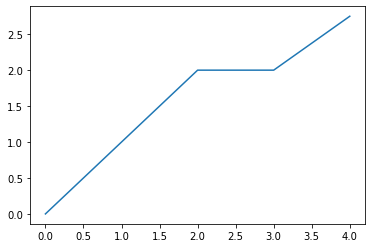

In [638]:
plt.plot(list(range(len(rets))), rets)

In [620]:
rets

array([0.  , 1.  , 2.  , 2.  , 2.75])

In [621]:
sells

date
1999-11-22    30.0
1999-11-24    50.0
Name: price, dtype: float64

In [659]:
    ###def roi_by_step(prices, buys, sells):
    ###buys, sells = strategy(prices, **kwargs)

    #prices = backtest.data.price
    buys = prices[[0, 3]]    ###backtest.buys[[0]]
    sells = prices[[2, 4]]  ###backtest.buys[[1]]

    #print(buys)
    #print(sells)

    buy_mask = np.full(len(prices), False)
    #buy_mask[buys] = True
    buy_mask[np.isin(prices.index, buys.index)] = True
    sell_mask = np.full(len(prices), False)
    #sell_mask[sells] = True
    sell_mask[np.isin(prices.index, sells.index)] = True
    
    last_sell_ratio = 1.0
    owned = False
    buy_shares = 0
    
    cash = 10
    buy_shares = 0
    prev_total = 0
    total = cash
    
    ratios = []
    for price, is_buy, is_sell in zip(prices, buy_mask, sell_mask):
        print(price, is_buy, is_sell, buy_shares, cash)
        if is_buy:
            owned = True
            buy_shares = cash / price
            cash = 0
        elif is_sell:
            owned = False
            cash = buy_shares * price
            buy_shares = 0
        
        total = cash + price * buy_shares

        print(price, buy_shares, cash, total, prev_total, (total / prev_total) if prev_total != 0 else np.nan)
        
        if prev_total != 0:
            ratios.append((total / prev_total) - 1)
        else:
            ratios.append(np.nan)
        
        prev_total = total
    
    ratios = np.array(ratios)
    print(ratios)
    pd.DataFrame({'returns': ratios}) #, 'cum_returns': np.cumprod(1 + ratios)})

10.0 True False 0 10
10.0 1.0 0 10.0 0 nan
20.0 False False 1.0 0
20.0 1.0 0 20.0 10.0 2.0
30.0 False True 1.0 0
30.0 0 30.0 30.0 20.0 1.5
40.0 True False 0 30.0
40.0 0.75 0 30.0 30.0 1.0
50.0 False True 0.75 0
50.0 0 37.5 37.5 30.0 1.25
[ nan 1.   0.5  0.   0.25]


,returns
0,NaN
1,1.00
2,0.50
3,0.00
4,0.25


In [675]:
#np.cumprod()


array([0.  , 1.  , 2.  , 2.  , 2.75])

In [668]:
(1 + ratios)

array([ nan, 2.  , 1.5 , 1.  , 1.25])

In [521]:
#x = pd.DataFrame({'AAPL': prices})
#prices = x.copy()

In [623]:
signals = pd.DataFrame(index=prices.index)
signals['signal'] = np.array([1, 1, 0, 1, 0])
signals['positions'] = signals['signal'].diff()

positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions = 1 * signals['signal']

In [624]:
initial_capital = 0

In [625]:
portfolio = pd.DataFrame({'value': positions * prices})
pos_diff = positions.diff()
pos_diff

date
1999-11-18    NaN
1999-11-19    0.0
1999-11-22   -1.0
1999-11-23    1.0
1999-11-24   -1.0
Name: signal, dtype: float64

In [626]:
portfolio

,value
date,
1999-11-18,10.0
1999-11-19,20.0
1999-11-22,0.0
1999-11-23,40.0
1999-11-24,0.0


In [627]:
portfolio['holdings'] = positions * prices #.sum(axis=1)
portfolio

,value,holdings
date,,
1999-11-18,10.0,10.0
1999-11-19,20.0,20.0
1999-11-22,0.0,0.0
1999-11-23,40.0,40.0
1999-11-24,0.0,0.0


In [628]:
pos_diff

date
1999-11-18    NaN
1999-11-19    0.0
1999-11-22   -1.0
1999-11-23    1.0
1999-11-24   -1.0
Name: signal, dtype: float64

In [629]:
portfolio.fillna(0.0)

,value,holdings
date,,
1999-11-18,10.0,10.0
1999-11-19,20.0,20.0
1999-11-22,0.0,0.0
1999-11-23,40.0,40.0
1999-11-24,0.0,0.0


In [630]:
pos_diff

date
1999-11-18    NaN
1999-11-19    0.0
1999-11-22   -1.0
1999-11-23    1.0
1999-11-24   -1.0
Name: signal, dtype: float64

In [631]:
portfolio['cash'] = initial_capital - (pos_diff*prices).cumsum() # .sum(axis=1)
portfolio = portfolio.fillna(0.0)

portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
portfolio

,value,holdings,cash,total,returns
date,,,,,
1999-11-18,10.0,10.0,0.0,10.0,NaN
1999-11-19,20.0,20.0,0.0,20.0,1.000000
1999-11-22,0.0,0.0,30.0,30.0,0.500000
1999-11-23,40.0,40.0,-10.0,30.0,0.000000
1999-11-24,0.0,0.0,40.0,40.0,0.333333


In [632]:
(np.cumprod(1 + portfolio['returns']) - 1).fillna(0.0)

date
1999-11-18    0.0
1999-11-19    1.0
1999-11-22    2.0
1999-11-23    2.0
1999-11-24    3.0
Name: returns, dtype: float64

In [633]:
prices

date
1999-11-18    10.0
1999-11-19    20.0
1999-11-22    30.0
1999-11-23    40.0
1999-11-24    50.0
Name: price, dtype: float64

In [634]:
rets

array([0.  , 1.  , 2.  , 2.  , 2.75])

In [635]:
sells

date
1999-11-22    30.0
1999-11-24    50.0
Name: price, dtype: float64

In [636]:
backtest.sells.tail()

date
2015-11-02    37.813
2016-03-18    39.489
2017-01-04    46.784
2017-04-24    54.209
2017-08-16    62.014
Name: price, dtype: float64

In [184]:
from abc import ABC, abstractmethod


class ConfigGrid(ABC):

    @staticmethod
    @abstractmethod
    def get_count():
        pass
    
    @staticmethod
    @abstractmethod
    def get_config(i):
        pass

# TODO: Use yield function instead
class SimpleMovingAvgConfigGrid(ConfigGrid):

    sma_list = [[5, 50],  [10, 100], [25, 200]]

    @staticmethod
    def get_count():
        return len(SimpleMovingAvgConfigGrid.sma_list)
    
    @staticmethod
    def get_config(i):
        sma_short, sma_long = SimpleMovingAvgConfigGrid.sma_list[i]
        return {
            'sma_short': sma_short,
            'sma_long': sma_long
        }


class BollingerBandConfigGrid(ConfigGrid):

    @staticmethod
    def get_count():
        return float('inf')
    
    @staticmethod
    def get_config(i):
        return {
            'sma': int(2 ** np.random.uniform(2, 6)),
            'sd': 2 ** np.random.uniform(0, 1)
        }


class BacktestParamSearch():

    def __init__(self, strategy_cls, ticker, config_grid_cls, num_runs=None, start_date=None, end_date=None):
        self.strategy_cls = strategy_cls
        self.ticker = ticker.lower()

        self.config_grid = config_grid_cls()
        self.num_runs = num_runs
        
        self.start_date = start_date
        self.end_date = end_date
        
        self.results = []

    def run(self):
        num_runs = self.config_grid.get_count()
        if self.num_runs is not None:
            num_runs = min(num_runs, self.num_runs)

        for i in range(num_runs):
            config = self.config_grid.get_config(i)
            print(config)
            backtest = Backtest(self.strategy_cls, self.ticker, config, self.start_date, self.end_date)
            self.results.append([config, backtest.run()])

        return self.results

if False:
    print('SMA')
    backtest_search = BacktestParamSearch(
        SimpleMovingAvgCrossOverStrategy, 
        example_ticker,
        SimpleMovingAvgConfigGrid,
        None)
    backtest_search.run()

print('Bollinger')
backtest_search = BacktestParamSearch(
    BollingerBandStrategy, 
    'a', ###TODO: example_ticker,
    BollingerBandConfigGrid,
    10)
backtest_search.run()

Bollinger
{'sma': 4, 'sd': 1.0430543738963898}
{'sma': 8, 'sd': 1.1643444252950932}
{'sma': 6, 'sd': 1.5907272617379395}
{'sma': 63, 'sd': 1.1604984631098039}
{'sma': 37, 'sd': 1.6950684276384596}
{'sma': 19, 'sd': 1.9413188148096796}
{'sma': 13, 'sd': 1.1931085811478122}
{'sma': 4, 'sd': 1.6198578987726693}
{'sma': 23, 'sd': 1.317819405515328}
{'sma': 6, 'sd': 1.7155976902541805}


[[{'sma': 4, 'sd': 1.0430543738963898}, -0.03999519460029721],
 [{'sma': 8, 'sd': 1.1643444252950932}, 0.8421253235622006],
 [{'sma': 6, 'sd': 1.5907272617379395}, 3.539940689761777],
 [{'sma': 63, 'sd': 1.1604984631098039}, -0.7698656586267194],
 [{'sma': 37, 'sd': 1.6950684276384596}, -0.7121796780701258],
 [{'sma': 19, 'sd': 1.9413188148096796}, -0.8157080096834524],
 [{'sma': 13, 'sd': 1.1931085811478122}, -0.03316861346776556],
 [{'sma': 4, 'sd': 1.6198578987726693}, 0.0],
 [{'sma': 23, 'sd': 1.317819405515328}, -0.7927018384463249],
 [{'sma': 6, 'sd': 1.7155976902541805}, 2.2633477218771696]]

In [185]:
def filter_tickers(min_usd_vol=0, min_data_points=0, min_price=0, start_date=None, end_date=None):
    ticker_list = []
    tickers = get_all_tickers()
    for t in tqdm(tickers):
        data = get_csv_data(t, start_date, end_date)

        if len(data) < min_data_points:
            continue

        if np.median(data['price'][-10:] * data['volume'][-10:]) < min_usd_vol:
            continue

        if min(data['price']) < min_price:
            continue

        ticker_list.append(t)

    return ticker_list

tickers = filter_tickers(min_usd_vol=50000000, min_data_points=2*252, min_price=0, start_date='2010-01-01', end_date='2015-12-31')

KeyboardInterrupt: 

In [191]:
start_time = datetime.now()
print(start_time)

params = [[SimpleMovingAvgCrossOverStrategy, BollingerBandStrategy],
          [SimpleMovingAvgConfigGrid, BollingerBandConfigGrid],
          [None, 3]]

results = []
for ticker in tqdm(tickers):
    for strategy, config, num_runs in zip(*params):
        print(ticker, strategy.__name__, config)
        backtest_search = BacktestParamSearch(strategy, ticker, config, num_runs)
        for b in backtest_search.run():
            results.append([ticker, strategy.__name__, *b])

print(datetime.now() - start_time)

2020-05-28 00:02:49.984891


a SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
a BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 22, 'sd': 1.033353372004164}
{'sma': 18, 'sd': 1.1344285022971579}
{'sma': 8, 'sd': 1.2274644391277003}
aa SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
aa BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 12, 'sd': 1.9987189523646756}
{'sma': 55, 'sd': 1.4389515043319152}
{'sma': 6, 'sd': 1.349079034483518}
aaba SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
aaba BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 6, 'sd': 1

{'sma_short': 25, 'sma_long': 200}
aem BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 27, 'sd': 1.0779039343476842}
{'sma': 44, 'sd': 1.423978412391189}
{'sma': 6, 'sd': 1.6029393580585511}
aep SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
aep BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 26, 'sd': 1.725652390320917}
{'sma': 5, 'sd': 1.0863912843647496}
{'sma': 18, 'sd': 1.3246502532869102}
aer SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
aer BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 31, 'sd': 1.1012383077522696}
{'sma': 43, 'sd': 1.5745942299823859}
{'sma': 40, 'sd': 1.5639858490512695}
aet SimpleMovingAvgCrossOverStrategy <class '__mai

{'sma': 10, 'sd': 1.497107046653401}
{'sma': 14, 'sd': 1.018283162584733}
ame SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ame BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 8, 'sd': 1.0296122537044279}
{'sma': 12, 'sd': 1.0579772907904108}
{'sma': 6, 'sd': 1.0261145964569607}
amg SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
amg BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 7, 'sd': 1.8762698205816568}
{'sma': 5, 'sd': 1.2904530937878784}
{'sma': 29, 'sd': 1.176042705769263}
amgn SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
amgn Boll

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
are BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 6, 'sd': 1.4066445689168205}
{'sma': 4, 'sd': 1.776943822725291}
{'sma': 6, 'sd': 1.2439923658991865}
arrs SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
arrs BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 6, 'sd': 1.3732294301044718}
{'sma': 21, 'sd': 1.0416932563550596}
{'sma': 24, 'sd': 1.2701871546953378}
ash SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ash BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 11, 'sd': 1.083580772747033}
{'sma': 6, 'sd': 1.331230730634594}
{'sma': 61, 'sd': 1.3094157514491593}
asml SimpleMoving

{'sma': 14, 'sd': 1.1835823302744068}
{'sma': 48, 'sd': 1.7076780825872742}
bby SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
bby BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 14, 'sd': 1.8689402830421271}
{'sma': 25, 'sd': 1.0116439452419117}
{'sma': 20, 'sd': 1.5258551178943018}
bc SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
bc BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 32, 'sd': 1.1692306521080635}
{'sma': 11, 'sd': 1.2994579007843134}
{'sma': 18, 'sd': 1.5477356984130966}
bce SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
bce B

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
bp BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 4, 'sd': 1.7815633553856798}
{'sma': 6, 'sd': 1.1546880051120199}
{'sma': 10, 'sd': 1.817851700183556}
bpl SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
bpl BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 14, 'sd': 1.4791299038449945}
{'sma': 6, 'sd': 1.5300201431139262}
{'sma': 8, 'sd': 1.1184559119691038}
brk-b SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
brk-b BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 30, 'sd': 1.0904702039046321}
{'sma': 22, 'sd': 1.3424306414911067}
{'sma': 28, 'sd': 1.5030009768723722}
brx SimpleMov

{'sma': 6, 'sd': 1.5427881530131409}
{'sma': 4, 'sd': 1.053225218431895}
cci SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
cci BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 12, 'sd': 1.4185476838066673}
{'sma': 8, 'sd': 1.2771512129245426}
{'sma': 33, 'sd': 1.2721936384637484}
ccl SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ccl BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 36, 'sd': 1.5621935804909477}
{'sma': 20, 'sd': 1.9815704969613093}
{'sma': 25, 'sd': 1.1065098066887729}
celg SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
celg B

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
cmi BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 22, 'sd': 1.1458646841229796}
{'sma': 5, 'sd': 1.2251702311647608}
{'sma': 5, 'sd': 1.0670525482669273}
cms SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
cms BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 4, 'sd': 1.7208985825225462}
{'sma': 26, 'sd': 1.6720418271202255}
{'sma': 27, 'sd': 1.5450390046758962}
cnc SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
cnc BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 14, 'sd': 1.0754994569197884}
{'sma': 28, 'sd': 1.8650852371161548}
{'sma': 51, 'sd': 1.165975735009496}
cni SimpleMovin

{'sma': 4, 'sd': 1.3224237025421157}
{'sma': 21, 'sd': 1.9084800728827918}
csx SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
csx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 12, 'sd': 1.1728480599089293}
{'sma': 6, 'sd': 1.788175442985726}
{'sma': 7, 'sd': 1.702305727844721}
ctl SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ctl BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 59, 'sd': 1.392007666001839}
{'sma': 13, 'sd': 1.0126540354929674}
{'sma': 51, 'sd': 1.0861943872665647}
ctrp SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ctrp Bol

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
dgx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 31, 'sd': 1.331892619161667}
{'sma': 28, 'sd': 1.2633157989920172}
{'sma': 31, 'sd': 1.2445928951202854}
dhi SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
dhi BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 38, 'sd': 1.6997356258682963}
{'sma': 8, 'sd': 1.7066101827700582}
{'sma': 4, 'sd': 1.5054356461185883}
dhr SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
dhr BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 19, 'sd': 1.0214376311301525}
{'sma': 5, 'sd': 1.0192434913819521}
{'sma': 10, 'sd': 1.2026240845646}
dia SimpleMovingAv

{'sma': 38, 'sd': 1.9209192245227193}
{'sma': 23, 'sd': 1.137410485861825}
dvn SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
dvn BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 41, 'sd': 1.245567768449218}
{'sma': 42, 'sd': 1.188383232675644}
{'sma': 14, 'sd': 1.2428063772262554}
dvy SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
dvy BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 12, 'sd': 1.8073836974476722}
{'sma': 8, 'sd': 1.2809669871981766}
{'sma': 12, 'sd': 1.3195117077479048}
dwdp SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
dwdp B

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
emn BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.4120589165923252}
{'sma': 37, 'sd': 1.1016789897162644}
{'sma': 23, 'sd': 1.8315855473546108}
emr SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
emr BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 7, 'sd': 1.3907283187258594}
{'sma': 25, 'sd': 1.4264182226075492}
{'sma': 11, 'sd': 1.3624847076878142}
enb SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
enb BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 13, 'sd': 1.5448212141646636}
{'sma': 10, 'sd': 1.3102472372547935}
{'sma': 12, 'sd': 1.438165790489123}
endp SimpleMov

{'sma': 34, 'sd': 1.3913179899502472}
{'sma': 14, 'sd': 1.3774855048196462}
ewg SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ewg BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 10, 'sd': 1.0796305771334287}
{'sma': 6, 'sd': 1.4212225588348966}
{'sma': 4, 'sd': 1.2252960631475627}
ewh SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ewh BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 22, 'sd': 1.8457038156141725}
{'sma': 14, 'sd': 1.0241471902032264}
{'sma': 7, 'sd': 1.4855219574177734}
ewj SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ewj Bo

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
fcx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.176658941899129}
{'sma': 27, 'sd': 1.6399074182776356}
{'sma': 63, 'sd': 1.493345762426668}
fds SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
fds BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 4, 'sd': 1.4286238545258063}
{'sma': 16, 'sd': 1.1774932706676238}
{'sma': 9, 'sd': 1.6121521412921558}
fdx SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
fdx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 12, 'sd': 1.033922776571845}
{'sma': 45, 'sd': 1.5779427148569536}
{'sma': 40, 'sd': 1.8296306968468656}
fe SimpleMovingAv

{'sma': 31, 'sd': 1.9389147732146248}
{'sma': 5, 'sd': 1.6665052173220598}
fti SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
fti BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 60, 'sd': 1.1850346949832375}
{'sma': 16, 'sd': 1.5485818694500886}
{'sma': 33, 'sd': 1.3337661654714508}
ftnt SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ftnt BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 7, 'sd': 1.6534764541836517}
{'sma': 61, 'sd': 1.014203918141622}
{'sma': 12, 'sd': 1.3534154288802664}
ftr SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ftr 

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
gmlp BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 16, 'sd': 1.1012862577176699}
{'sma': 33, 'sd': 1.0007673529412904}
{'sma': 6, 'sd': 1.8074582875355054}
gold SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
gold BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 12, 'sd': 1.9681503107317624}
{'sma': 30, 'sd': 1.6836248179281268}
{'sma': 22, 'sd': 1.161627258239217}
googl SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
googl BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 7, 'sd': 1.1172544074914332}
{'sma': 7, 'sd': 1.7304755228242337}
{'sma': 16, 'sd': 1.2667105038423525}
gpn Simp

{'sma': 5, 'sd': 1.0808551899513135}
{'sma': 42, 'sd': 1.426933981200862}
hd SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
hd BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 50, 'sd': 1.8238040751498588}
{'sma': 4, 'sd': 1.5887167435590912}
{'sma': 33, 'sd': 1.1095214497849488}
hds SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
hds BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 11, 'sd': 1.5762306374106023}
{'sma': 38, 'sd': 1.250658187004931}
{'sma': 19, 'sd': 1.9139491979214927}
hedj SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
hedj Bol

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
hyg BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 15, 'sd': 1.0908954661089667}
{'sma': 36, 'sd': 1.2360363826630525}
{'sma': 4, 'sd': 1.3741143113824612}
hznp SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
hznp BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 23, 'sd': 1.639409382515248}
{'sma': 28, 'sd': 1.1674766238105527}
{'sma': 11, 'sd': 1.7874035668413004}
iau SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
iau BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 44, 'sd': 1.8991566976741492}
{'sma': 12, 'sd': 1.1769872097243017}
{'sma': 4, 'sd': 1.2529061148272576}
ibb SimpleMo

{'sma': 7, 'sd': 1.1602565171545056}
{'sma': 31, 'sd': 1.121007018932858}
intu SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
intu BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 15, 'sd': 1.1897381600806638}
{'sma': 18, 'sd': 1.1119828998032122}
{'sma': 20, 'sd': 1.0733494780438804}
ions SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ions BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 10, 'sd': 1.7324478306305022}
{'sma': 25, 'sd': 1.9734257054092603}
{'sma': 26, 'sd': 1.831760701490679}
ip SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ip 

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
iye BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 19, 'sd': 1.4637362254132358}
{'sma': 4, 'sd': 1.269812162267939}
{'sma': 45, 'sd': 1.1043286789271425}
iyf SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
iyf BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 4, 'sd': 1.0295403642163632}
{'sma': 8, 'sd': 1.4305918041632175}
{'sma': 30, 'sd': 1.5519613634414522}
iyr SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
iyr BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 20, 'sd': 1.2331184351763134}
{'sma': 17, 'sd': 1.5010406001938579}
{'sma': 4, 'sd': 1.0797592801385816}
iyt SimpleMoving

{'sma': 5, 'sd': 1.8971341535933546}
{'sma': 4, 'sd': 1.4120549327657923}
klac SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
klac BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 8, 'sd': 1.5821895425674408}
{'sma': 17, 'sd': 1.3063740768426924}
{'sma': 19, 'sd': 1.8910771440890934}
kmb SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
kmb BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.926911023073861}
{'sma': 41, 'sd': 1.8537269891013062}
{'sma': 9, 'sd': 1.2221877951018594}
kmi SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
kmi Bol

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
lly BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 20, 'sd': 1.204580632600843}
{'sma': 5, 'sd': 1.2592958207343707}
{'sma': 4, 'sd': 1.540344282627905}
lmt SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
lmt BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 48, 'sd': 1.4863062581161228}
{'sma': 51, 'sd': 1.161812347865126}
{'sma': 5, 'sd': 1.0560017029593478}
lnc SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
lnc BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 7, 'sd': 1.4272183369185931}
{'sma': 32, 'sd': 1.6648974050076064}
{'sma': 14, 'sd': 1.4612973965838871}
lng SimpleMovingAv

{'sma': 9, 'sd': 1.1437466071164055}
{'sma': 37, 'sd': 1.7405695377542456}
mchp SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
mchp BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 43, 'sd': 1.2180225875521544}
{'sma': 21, 'sd': 1.8247237186096161}
{'sma': 30, 'sd': 1.3433575547644554}
mck SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
mck BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 14, 'sd': 1.1067139092723195}
{'sma': 23, 'sd': 1.8012354238706347}
{'sma': 8, 'sd': 1.882676367557063}
mco SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
mco 

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
mmp BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 18, 'sd': 1.936111720242634}
{'sma': 21, 'sd': 1.320536069022015}
{'sma': 4, 'sd': 1.9011630374782666}
mnk SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
mnk BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 14, 'sd': 1.6176721935223592}
{'sma': 34, 'sd': 1.7043861759184282}
{'sma': 4, 'sd': 1.2665285241061914}
mnst SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
mnst BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 18, 'sd': 1.5383271098034208}
{'sma': 10, 'sd': 1.7579085628744604}
{'sma': 51, 'sd': 1.256274276032593}
mo SimpleMovin

{'sma': 21, 'sd': 1.3274557237270181}
{'sma': 49, 'sd': 1.9541062356997483}
nbix SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
nbix BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 52, 'sd': 1.755166475755166}
{'sma': 50, 'sd': 1.6467962944949597}
{'sma': 8, 'sd': 1.4639622046704701}
nbl SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
nbl BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 46, 'sd': 1.1487248072365868}
{'sma': 8, 'sd': 1.1941774787472363}
{'sma': 27, 'sd': 1.0794750579290757}
nbr SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
nbr 

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ntrs BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 57, 'sd': 1.0369354540050904}
{'sma': 22, 'sd': 1.7289006565270706}
{'sma': 61, 'sd': 1.5710762107191942}
nue SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
nue BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 7, 'sd': 1.4822104564925607}
{'sma': 9, 'sd': 1.8303602925564408}
{'sma': 12, 'sd': 1.6326769356197426}
nugt SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
nugt BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 42, 'sd': 1.0821783228771866}
{'sma': 19, 'sd': 1.6248861142602884}
{'sma': 23, 'sd': 1.3237734677913884}
nvda Simpl

{'sma': 6, 'sd': 1.980668929200054}
{'sma': 18, 'sd': 1.0761541151260248}
oxy SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
oxy BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 23, 'sd': 1.751971479283152}
{'sma': 16, 'sd': 1.4055652454718313}
{'sma': 20, 'sd': 1.7143894514233213}
p SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
p BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 9, 'sd': 1.6732231030982894}
{'sma': 15, 'sd': 1.223100714734888}
{'sma': 24, 'sd': 1.8309186933829265}
paa SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
paa Bollinge

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
ph BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 55, 'sd': 1.4107106261533895}
{'sma': 36, 'sd': 1.1418213120488632}
{'sma': 7, 'sd': 1.1228907303025246}
phm SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
phm BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 20, 'sd': 1.488134375960482}
{'sma': 9, 'sd': 1.398470311114186}
{'sma': 17, 'sd': 1.8601406770972708}
pii SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
pii BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 49, 'sd': 1.2960231124316846}
{'sma': 10, 'sd': 1.5358848032094996}
{'sma': 14, 'sd': 1.7447077035981846}
pir SimpleMoving

{'sma': 11, 'sd': 1.2205054596282077}
{'sma': 5, 'sd': 1.5855328551369403}
q SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
q BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 6, 'sd': 1.3565897993983127}
{'sma': 24, 'sd': 1.1315312793394703}
{'sma': 20, 'sd': 1.696377559260547}
qcom SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
qcom BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 30, 'sd': 1.6908662678479582}
{'sma': 22, 'sd': 1.0074759421406747}
{'sma': 5, 'sd': 1.263593536184162}
qep SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
qep Bollin

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
rl BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 6, 'sd': 1.3995052171850477}
{'sma': 23, 'sd': 1.0935561041474937}
{'sma': 5, 'sd': 1.3542069614808854}
rlgy SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
rlgy BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 14, 'sd': 1.4708581013283453}
{'sma': 13, 'sd': 1.2000925174112869}
{'sma': 9, 'sd': 1.7272792504540502}
rmd SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
rmd BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 38, 'sd': 1.6084089695110255}
{'sma': 52, 'sd': 1.7847053242182156}
{'sma': 50, 'sd': 1.8905750505883592}
rok SimpleMov

{'sma': 49, 'sd': 1.3645269344952413}
{'sma': 4, 'sd': 1.7072573087910443}
sds SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
sds BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 11, 'sd': 1.0186888783774752}
{'sma': 15, 'sd': 1.6399237763302585}
{'sma': 58, 'sd': 1.069642040369706}
sdy SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
sdy BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 10, 'sd': 1.7220390049961298}
{'sma': 5, 'sd': 1.9696986573601092}
{'sma': 17, 'sd': 1.2688245360170136}
see SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
see Bo

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
sohu BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 15, 'sd': 1.22857958010633}
{'sma': 35, 'sd': 1.5843944535502308}
{'sma': 19, 'sd': 1.0367482818357143}
spg SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
spg BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 4, 'sd': 1.4629848252642685}
{'sma': 20, 'sd': 1.5689258081729163}
{'sma': 58, 'sd': 1.5665487521053316}
spgi SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
spgi BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.1040646828683731}
{'sma': 18, 'sd': 1.9641786895678786}
{'sma': 13, 'sd': 1.9564140328705524}
splk SimpleM

{'sma': 14, 'sd': 1.1920576884330332}
{'sma': 18, 'sd': 1.0142018398978154}
swks SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
swks BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 43, 'sd': 1.9142621856486803}
{'sma': 45, 'sd': 1.6291884330842383}
{'sma': 5, 'sd': 1.2147336590913909}
swn SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
swn BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 11, 'sd': 1.957725044080343}
{'sma': 8, 'sd': 1.5296618050852628}
{'sma': 17, 'sd': 1.9894916576584596}
syk SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
syk 

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
tmk BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 52, 'sd': 1.3280297719027712}
{'sma': 8, 'sd': 1.2820881512453435}
{'sma': 49, 'sd': 1.8072739959115445}
tmo SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
tmo BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 17, 'sd': 1.9920555949430045}
{'sma': 10, 'sd': 1.2874609467940423}
{'sma': 17, 'sd': 1.1462108658497583}
tmus SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
tmus BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 4, 'sd': 1.370877148181794}
{'sma': 50, 'sd': 1.9163134087061855}
{'sma': 17, 'sd': 1.3676951951446783}
tna SimpleMo

{'sma': 41, 'sd': 1.5054465827132861}
{'sma': 4, 'sd': 1.8513985557274262}
twx SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
twx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 20, 'sd': 1.2962179267523306}
{'sma': 4, 'sd': 1.0361808383100672}
{'sma': 48, 'sd': 1.8125092149035396}
txn SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
txn BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 38, 'sd': 1.2767863195009281}
{'sma': 34, 'sd': 1.0762843677304537}
{'sma': 8, 'sd': 1.5786086183557921}
txt SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
txt Bo

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
usb BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 6, 'sd': 1.235087785654266}
{'sma': 15, 'sd': 1.3021826864370003}
{'sma': 30, 'sd': 1.3974499319294063}
usg SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
usg BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 22, 'sd': 1.964513573953994}
{'sma': 20, 'sd': 1.572290386295764}
{'sma': 51, 'sd': 1.9341513133876116}
usmv SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
usmv BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 13, 'sd': 1.4123261238448097}
{'sma': 9, 'sd': 1.2460510787522905}
{'sma': 30, 'sd': 1.3485515882002432}
uso SimpleMovi

{'sma': 21, 'sd': 1.153802324618581}
{'sma': 7, 'sd': 1.3984499382682951}
vips SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
vips BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 21, 'sd': 1.56791962009188}
{'sma': 10, 'sd': 1.2326462346052676}
{'sma': 9, 'sd': 1.2285224101312306}
vlo SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
vlo BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 17, 'sd': 1.1752093957328709}
{'sma': 6, 'sd': 1.0549153203954185}
{'sma': 4, 'sd': 1.035143467894607}
vly SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
vly Bolli

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
vwo BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.5958441172150224}
{'sma': 13, 'sd': 1.3210373089751883}
{'sma': 4, 'sd': 1.5515772316187963}
vxx SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
vxx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 41, 'sd': 1.0485263019490878}
{'sma': 4, 'sd': 1.5307728744523472}
{'sma': 49, 'sd': 1.1762340432153053}
vym SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
vym BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.5253804439326226}
{'sma': 12, 'sd': 1.1132361263539314}
{'sma': 5, 'sd': 1.20345252238667}
vz SimpleMovingAvg

{'sma': 18, 'sd': 1.3433850193503116}
{'sma': 4, 'sd': 1.7998908364959185}
wuba SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
wuba BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 27, 'sd': 1.044517664281468}
{'sma': 48, 'sd': 1.8068392223411756}
{'sma': 60, 'sd': 1.9255221587850788}
wy SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
wy BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 15, 'sd': 1.5696045176120323}
{'sma': 21, 'sd': 1.3261502748696656}
{'sma': 23, 'sd': 1.0741822981633427}
wyn SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
wyn B

{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
xop BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 5, 'sd': 1.5616746474722127}
{'sma': 7, 'sd': 1.5055309070298133}
{'sma': 16, 'sd': 1.6585633438701817}
xrt SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
xrt BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 27, 'sd': 1.7978326570150396}
{'sma': 10, 'sd': 1.0678310190073999}
{'sma': 63, 'sd': 1.1439001975381773}
xrx SimpleMovingAvgCrossOverStrategy <class '__main__.SimpleMovingAvgConfigGrid'>
{'sma_short': 5, 'sma_long': 50}
{'sma_short': 10, 'sma_long': 100}
{'sma_short': 25, 'sma_long': 200}
xrx BollingerBandStrategy <class '__main__.BollingerBandConfigGrid'>
{'sma': 10, 'sd': 1.0912328020156115}
{'sma': 21, 'sd': 1.997868254469386}
{'sma': 20, 'sd': 1.4342368160632266}
yum SimpleMovi

In [201]:
import pickle

with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [205]:
with open('results.pickle', 'rb') as handle:
    results_file = pickle.load(handle)
    
results == results_file

True

In [208]:
results = np.array(results)

In [217]:
returns = results[:, [0, 1, 3]]

In [219]:
returns = pd.DataFrame({'ticker': returns[:, 0], 'strategy': returns[:, 1], 'return': returns[:, 2]})

In [237]:
r = returns[returns.strategy == 'SimpleMovingAvgCrossOverStrategy']['return']

#plt.hist(r, bins=np.linspace(np.quantile(r, .01), np.quantile(r, .99), 256))

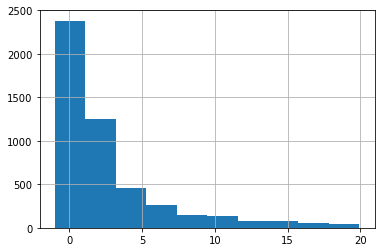

In [238]:
returns[abs(returns['return']) < 20]['return'].hist()

In [ ]:
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']   # This strategy buys 100 shares
        return positions

In [ ]:
    def backtest_portfolio(self):
        portfolio = self.positions*self.bars['Adj Close']
        pos_diff = self.positions.diff()

        portfolio['holdings'] = (self.positions*self.bars['Adj Close']).sum(axis=1)
        portfolio['cash'] = self.initial_capital - (pos_diff*self.bars['Adj Close']).sum(axis=1).cumsum()

        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio